In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import time
import optuna
import argparse
from pprint import pprint
from toolz.dicttoolz import valmap
#from forecasting.models import RNNBasedModel, RNNAttentionModel
#from forecasting.utils import Metrics, input_output_splitter, save_result
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from tensorflow.keras.models import load_model,model_from_json
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
import datetime as dt
tf.config.experimental.enable_op_determinism()
from sklearn.preprocessing import MinMaxScaler
from pickle import dump,load
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from pickle import dump,load
from matplotlib import pyplot as plt
import datetime as dt
from matplotlib import rcParams
SEED = 7
tf.keras.utils.set_random_seed(SEED)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


features_options = [
    ["SIN"],
    ["SIN", "Temperature", "Humidity", "Temperature t+24", "Humidity t+24"],
    ["SIN", "Temperature", "Humidity", "Temperature t+24", "Humidity t+24",
                         "Month_cos", "Month_sin", "Month_cos t+24", "Month_sin t+24"],
    ["SIN", "Temperature", "Humidity", "Temperature t+24", "Humidity t+24", "Year", "Year t+24"],
    ["SIN", "Temperature", "Humidity", "Temperature t+24", "Humidity t+24", "Year", "Year t+24",
     "Month_cos", "Month_sin", "Month_cos t+24", "Month_sin t+24"],
    ["SIN", "Temperature", "Humidity", "Temperature t+24", "Humidity t+24", "Year", "Year t+24",
    "weekday_cos", "weekday_sin", "weekday_cos t+24", "weekday_sin t+24"],
    ["SIN", "Temperature", "Humidity", "Temperature t+24", "Humidity t+24",
          "Month_cos", "Month_sin", "Month_cos t+24", "Month_sin t+24",
         "weekday_cos", "weekday_sin", "weekday_cos t+24", "weekday_sin t+24"],
    ["SIN", "Temperature", "Humidity", "Temperature t+24", "Humidity t+24", "Year", "Year t+24",
    "weekday_cos", "weekday_sin", "weekday_cos t+24", "weekday_sin t+24"]

]





In [ ]:
def preparar_datos_salto(tamanio_ventana,horizonte, data):
    n_features=len(data.columns)
    x_train = np.zeros(((len(data)-tamanio_ventana-horizonte+1)//horizonte+1,tamanio_ventana, n_features))
    y_train= np.zeros(((len(data)-tamanio_ventana-horizonte+1)//horizonte+1, horizonte ))
    for i in range(tamanio_ventana, len(data)-horizonte +1,horizonte):
        x_train[(i-tamanio_ventana)//horizonte, :, :] = data.iloc[(i-tamanio_ventana):(i), :]
        y_train[(i-tamanio_ventana)//horizonte, :] = data['SIN'].iloc[(i):(i+horizonte)]
    return x_train,y_train
def exponential_decay_weights(seq_length, decay_factor):
    weights = np.exp(-decay_factor * np.arange(seq_length))
    return weights / np.sum(weights)  # Normalize weights to sum up to 1

def multi_step_loss_pos(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    seq_length = 24  # Length of the time series
    decay_factor = -0.05  # Controls the rate of decay
    weights = tf.constant(exponential_decay_weights(seq_length, decay_factor), dtype=tf.float32)
    weighted_pmse = tf.math.multiply(tf.square(y_true - y_pred), tf.expand_dims(weights, axis=-1))
    mwpmse_loss = tf.reduce_mean(weighted_pmse)
    num_steps = 24  # Number of steps in each prediction
    adjusted_loss = mwpmse_loss / num_steps
    return adjusted_loss
def multi_step_loss_neg(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    seq_length = 24  # Length of the time series
    decay_factor = 0.05  # Controls the rate of decay
    weights = tf.constant(exponential_decay_weights(seq_length, decay_factor), dtype=tf.float32)
    weighted_pmse = tf.math.multiply(tf.square(y_true - y_pred), tf.expand_dims(weights, axis=-1))
    mwpmse_loss = tf.reduce_mean(weighted_pmse)
    num_steps = 24  # Number of steps in each prediction
    adjusted_loss = mwpmse_loss / num_steps
    return adjusted_loss
def multi_pen_step_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    max_true = tf.reduce_max(y_true)  # Maximum value in y_true
    mse = tf.square(y_true - y_pred)  # Normal MSE loss
    penalized_mse = tf.where(y_true >= max_true*0.9, mse * 4.0, mse)
    mwpmse_loss = tf.reduce_mean(penalized_mse)
    num_steps = 24  # Number of steps in each prediction
    adjusted_loss = mwpmse_loss / num_steps
    return adjusted_loss

def multi_penw_step_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    max_true = tf.reduce_max(y_true)  # Maximum value in y_true
    mse = tf.square(y_true - y_pred)  # Normal MSE loss
    penalized_mse = tf.where(y_true >= max_true*0.8, mse * 2.0, mse)
    penalized_mse = tf.where(y_true >= max_true*0.9, mse * 2.0, mse)

    mwpmse_loss = tf.reduce_mean(penalized_mse)
    num_steps = 24  # Number of steps in each prediction
    adjusted_loss = mwpmse_loss / num_steps
    return adjusted_loss
def multi_penwF_step_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    max_true = tf.reduce_max(y_true)  # Maximum value in y_true
    mse = tf.square(y_true - y_pred)  # Normal MSE loss
    weighted_pmse = tf.math.multiply( mse, y_true)

    mwpmse_loss = tf.reduce_mean(weighted_pmse)
    num_steps = 24  # Number of steps in each prediction
    adjusted_loss = mwpmse_loss / num_steps
    return adjusted_loss

def create_model(tamanio_ventana,cantidad_unidades,nfeatures,dropout):
    model = keras.Sequential()
    #model.add( tf.keras.layers.GRU( cantidad_unidades, input_shape=(tamanio_ventana, nfeatures)))
    model.add(keras.layers.Bidirectional(keras.layers.GRU(cantidad_unidades),input_shape=(tamanio_ventana, nfeatures)))
    model.add( tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(24))

    return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df)

                        SIN  Temperature   Humidity
Date                                               
2008-01-01 00:00:00  1060.5    25.698615  96.204327
2008-01-01 01:00:00   990.0    25.293764  96.429905
2008-01-01 02:00:00   957.5    24.888913  96.655483
2008-01-01 03:00:00   919.5    24.484062  96.881061
2008-01-01 04:00:00   890.8    24.349906  96.058989
...                     ...          ...        ...
2022-12-31 19:00:00  3067.0    39.585124  19.229816
2022-12-31 20:00:00  3354.0    38.902114  20.348636
2022-12-31 21:00:00  3454.0    38.219104  21.467456
2022-12-31 22:00:00  3120.0    35.726600  25.315716
2022-12-31 23:00:00  2922.0    33.234095  29.163976

[131496 rows x 3 columns]


In [ ]:
file_path = '/content/drive/MyDrive/Datasets/processed_dataset(3).csv'
df = pd.read_csv(file_path)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df["Temperature t+24"] = df["Temperature"].shift(periods=-24)
df["Humidity t+24"] = df["Humidity"].shift(periods=-24)
df["Month"] = df.index.month
df["Month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df["Month_cos"] = np.cos(2 * np.pi * df.index.month / 12)
df["Month t+24"] = df["Month"].shift(periods=-24)
df["Month_sin t+24"] = df["Month_sin"].shift(periods=-24)
df["Month_cos t+24"] = df["Month_cos"].shift(periods=-24)
df["Quarter"] = df.index.quarter
df["Quarter_sin"] = np.sin(2 * np.pi * df.index.quarter / 4)
df["Quarter_cos"] = np.cos(2 * np.pi * df.index.quarter / 4)
df["Quarter t+24"] = df["Quarter"].shift(periods=-24)
df["Quarter_sin t+24"] = df["Quarter_sin"].shift(periods=-24)
df["Quarter_cos t+24"] = df["Quarter_cos"].shift(periods=-24)
df["Year"] = df.index.year
df["Year t+24"] = df["Year"].shift(periods=-24)
df['week_cos'] =  np.cos(2 * np.pi * df.index.isocalendar().week / 53)
df['week_sin'] =  np.sin(2 * np.pi * df.index.isocalendar().week / 53)
df["week_sin t+24"] = df["week_sin"].shift(periods=-24)
df["week_cos t+24"] = df["week_cos"].shift(periods=-24)
df['weekday_cos'] = np.sin(2 * np.pi * (df.index.weekday+1) / 7)
df['weekday_sin'] = np.cos(2 * np.pi * (df.index.weekday+1) / 7)
df["weekday_sin t+24"] = df["weekday_sin"].shift(periods=-24)
df["weekday_cos t+24"] = df["weekday_cos"].shift(periods=-24)

dataframe = df


In [ ]:
print(df)

In [ ]:
model_selection='BiGRU'
keras.backend.clear_session()
year_ini= 2009
hist_window = 336
num_units = 48
features = 7
batch_size = 16
learning_rate = 5e-4
dropout =  0.2


In [ ]:
print(dataframe[features_options[features]])

In [ ]:
datos_normm=dataframe[features_options[features]]

In [ ]:
desde=(dt.datetime.strptime(str(2009)+'-01-01', '%Y-%m-%d')- dt.timedelta(hours=hist_window )).strftime('%Y/%m/%d')
print(datos_normm.loc[desde:'2022-12-31'])

In [ ]:
# year_ini=2009
#train_range = ('2009-01-01', '2016-12-31')
# validation_range = ('2017-01-01', '2019-12-31')
train_range = ('2009-01-01', '2019-12-31')
validation_range = ('2020-01-01', '2022-12-31')
valyear=2020
loss = 1
function=[keras.losses.mean_squared_error,keras.losses.mean_absolute_error, multi_pen_step_loss,multi_step_loss_neg,multi_step_loss_pos,multi_penw_step_loss,multi_penwF_step_loss]
loss_fun=function[loss]
target = 'SIN'
pred_window = 24
jump = True
scalin_type = 'minmax'
epochs = 150


scalin_type = 'minmax'
epochs = 150
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
datos_normm=dataframe[features_options[features]]
nfeatures=len(datos_normm.columns)
desde=(dt.datetime.strptime(str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(hours=hist_window )).strftime('%Y/%m/%d')
Scaler = MinMaxScaler()
Scaler.fit(datos_normm.loc[desde:'2022-12-31'])
# Scaler.fit(datos_normm)
def lr_step_decay(epoch, lr):
    drop = 0.5  # Factor by which the learning rate will be reduced
    epochs_drop = 10  # Number of epochs after which to apply the drop
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop))

    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)


train = datos_normm.loc[desde:str(valyear-1)+'-12-31']
ix=train.index
trainScaled = pd.DataFrame(Scaler.transform(train),columns=train.columns)
trainScaled.set_index(ix)
x_train, y_train=preparar_datos_salto( hist_window,pred_window, trainScaled)

desde=(dt.datetime.strptime(str(valyear)+'-01-01', '%Y-%m-%d')- dt.timedelta(hours=hist_window)).strftime('%Y/%m/%d')
val = datos_normm.loc[desde:str(valyear+2)+'-12-31']
ix=val.index
valScaled = pd.DataFrame(Scaler.transform(val),columns=val.columns)
valScaled.set_index(ix)
x_val, y_val=preparar_datos_salto( hist_window,pred_window, valScaled)


start_time = time.time()
model = create_model( hist_window, num_units,nfeatures,dropout)
early_stopping = callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks_list = [early_stopping,lr_scheduler]

initial_learning_rate=learning_rate
def lr_step_decay(epoch, lr):
    drop = 0.5  # Factor by which the learning rate will be reduced
    epochs_drop = 10  # Number of epochs after which to apply the drop
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop))
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)
callbacks_list = [early_stopping,lr_scheduler ]


model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),loss=loss_fun,metrics=[ keras.metrics.RootMeanSquaredError()])
history=model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_val, y_val),callbacks=callbacks_list,verbose=1, shuffle=False)

predictions = Scaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]
y_validation=Scaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]

ixmax=np.argmax(y_validation.reshape(-1,24),axis=1)
hmaxerr=((predictions.reshape(-1,24)[np.arange(predictions.reshape(-1,24).shape[0]),ixmax]-np.max(y_validation.reshape(-1,24),axis=1))/np.max(y_validation.reshape(-1,24),axis=1))
hsup=np.percentile(hmaxerr,99)
hinf=np.percentile(hmaxerr,1)
mse=mean_squared_error( y_validation, predictions)
rmse=np.sqrt(mse)
error=np.abs(y_validation-predictions)
Error_95_=np.percentile(error,95)
maxError_=max_error(y_validation, predictions)

r2_=r2_score(y_validation, predictions)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )+" Error95:" + str(Error_95_))
print( "hsup: " + str(hsup)+" hinf:" + str(hinf))
print( "hmaxerr5: " + str(np.percentile(error,5)))
print( "hmaxerr50: " + str(np.percentile(error,50)))
print( "hmaxerr95: " + str(np.percentile(error,95)))





Epoch 1/150
252/252 [==============================] - 106s 402ms/step - loss: 0.1051 - root_mean_squared_error: 0.1359 - val_loss: 0.0773 - val_root_mean_squared_error: 0.1041 - lr: 5.0000e-04
Epoch 2/150
252/252 [==============================] - 68s 271ms/step - loss: 0.0654 - root_mean_squared_error: 0.0843 - val_loss: 0.0632 - val_root_mean_squared_error: 0.0832 - lr: 5.0000e-04
Epoch 3/150
252/252 [==============================] - 70s 280ms/step - loss: 0.0537 - root_mean_squared_error: 0.0693 - val_loss: 0.0521 - val_root_mean_squared_error: 0.0694 - lr: 5.0000e-04
Epoch 4/150
252/252 [==============================] - 76s 301ms/step - loss: 0.0452 - root_mean_squared_error: 0.0589 - val_loss: 0.0468 - val_root_mean_squared_error: 0.0640 - lr: 5.0000e-04
Epoch 5/150
252/252 [==============================] - 72s 286ms/step - loss: 0.0410 - root_mean_squared_error: 0.0542 - val_loss: 0.0521 - val_root_mean_squared_error: 0.0692 - lr: 5.0000e-04
Epoch 6/150
252/252 [=============

In [ ]:
#from pickle import dump,load
model_json = model.to_json()
with open("model01.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelw01.h5")

dump(y_validation, open('test01.pkl', 'wb'))
dump(predictions, open('testpred01.pkl', 'wb'))

In [ ]:
from tensorflow.keras.models import load_model,model_from_json
json_file = open("model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("modelw.h5")
print("Loaded model from disk")
y_validation=load(open('test.pkl', 'rb'))
predictions=load(open('testpred.pkl', 'rb'))

FileNotFoundError: ignored

In [ ]:
#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error


In [ ]:
ixmax=np.argmax(y_validation.reshape(-1,24),axis=1)
hmaxerr=((predictions.reshape(-1,24)[np.arange(predictions.reshape(-1,24).shape[0]),ixmax]-np.max(y_validation.reshape(-1,24),axis=1))/np.max(y_validation.reshape(-1,24),axis=1))
hsup=np.percentile(hmaxerr,99)
hinf=np.percentile(hmaxerr,1)
mse=mean_squared_error( y_validation, predictions)
rmse=np.sqrt(mse)
error=np.abs(y_validation-predictions)
Error_95_=np.percentile(error,95)
maxError_=max_error(y_validation, predictions)

r2_=r2_score(y_validation, predictions)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )+" Error95:" + str(Error_95_))
print( "hsup: " + str(hsup)+" hinf:" + str(hinf))
print( "hmaxerr5: " + str(np.percentile(error,5)))
print( "hmaxerr50: " + str(np.percentile(error,50)))
print( "hmaxerr95: " + str(np.percentile(error,95)))


MSE: 43611.56598824368 RMSE:208.83382386060856
MaxError: 1346.8256174921962 R2:0.849504698479564 Error95:459.4941750079393
hsup: 0.08952139088052556 hinf:-0.23662232603839783
hmaxerr5: 6.573830193283209
hmaxerr50: 90.6760876551275
hmaxerr95: 459.4941750079393


In [ ]:
dtin = pd.date_range(start=validation_range[0], end=validation_range[1], freq='H')


0.08952139088052556
-0.059411493546796285
-0.23662232603839783
0.38632526788140614
0.1272742729358636
0.03595804052834973


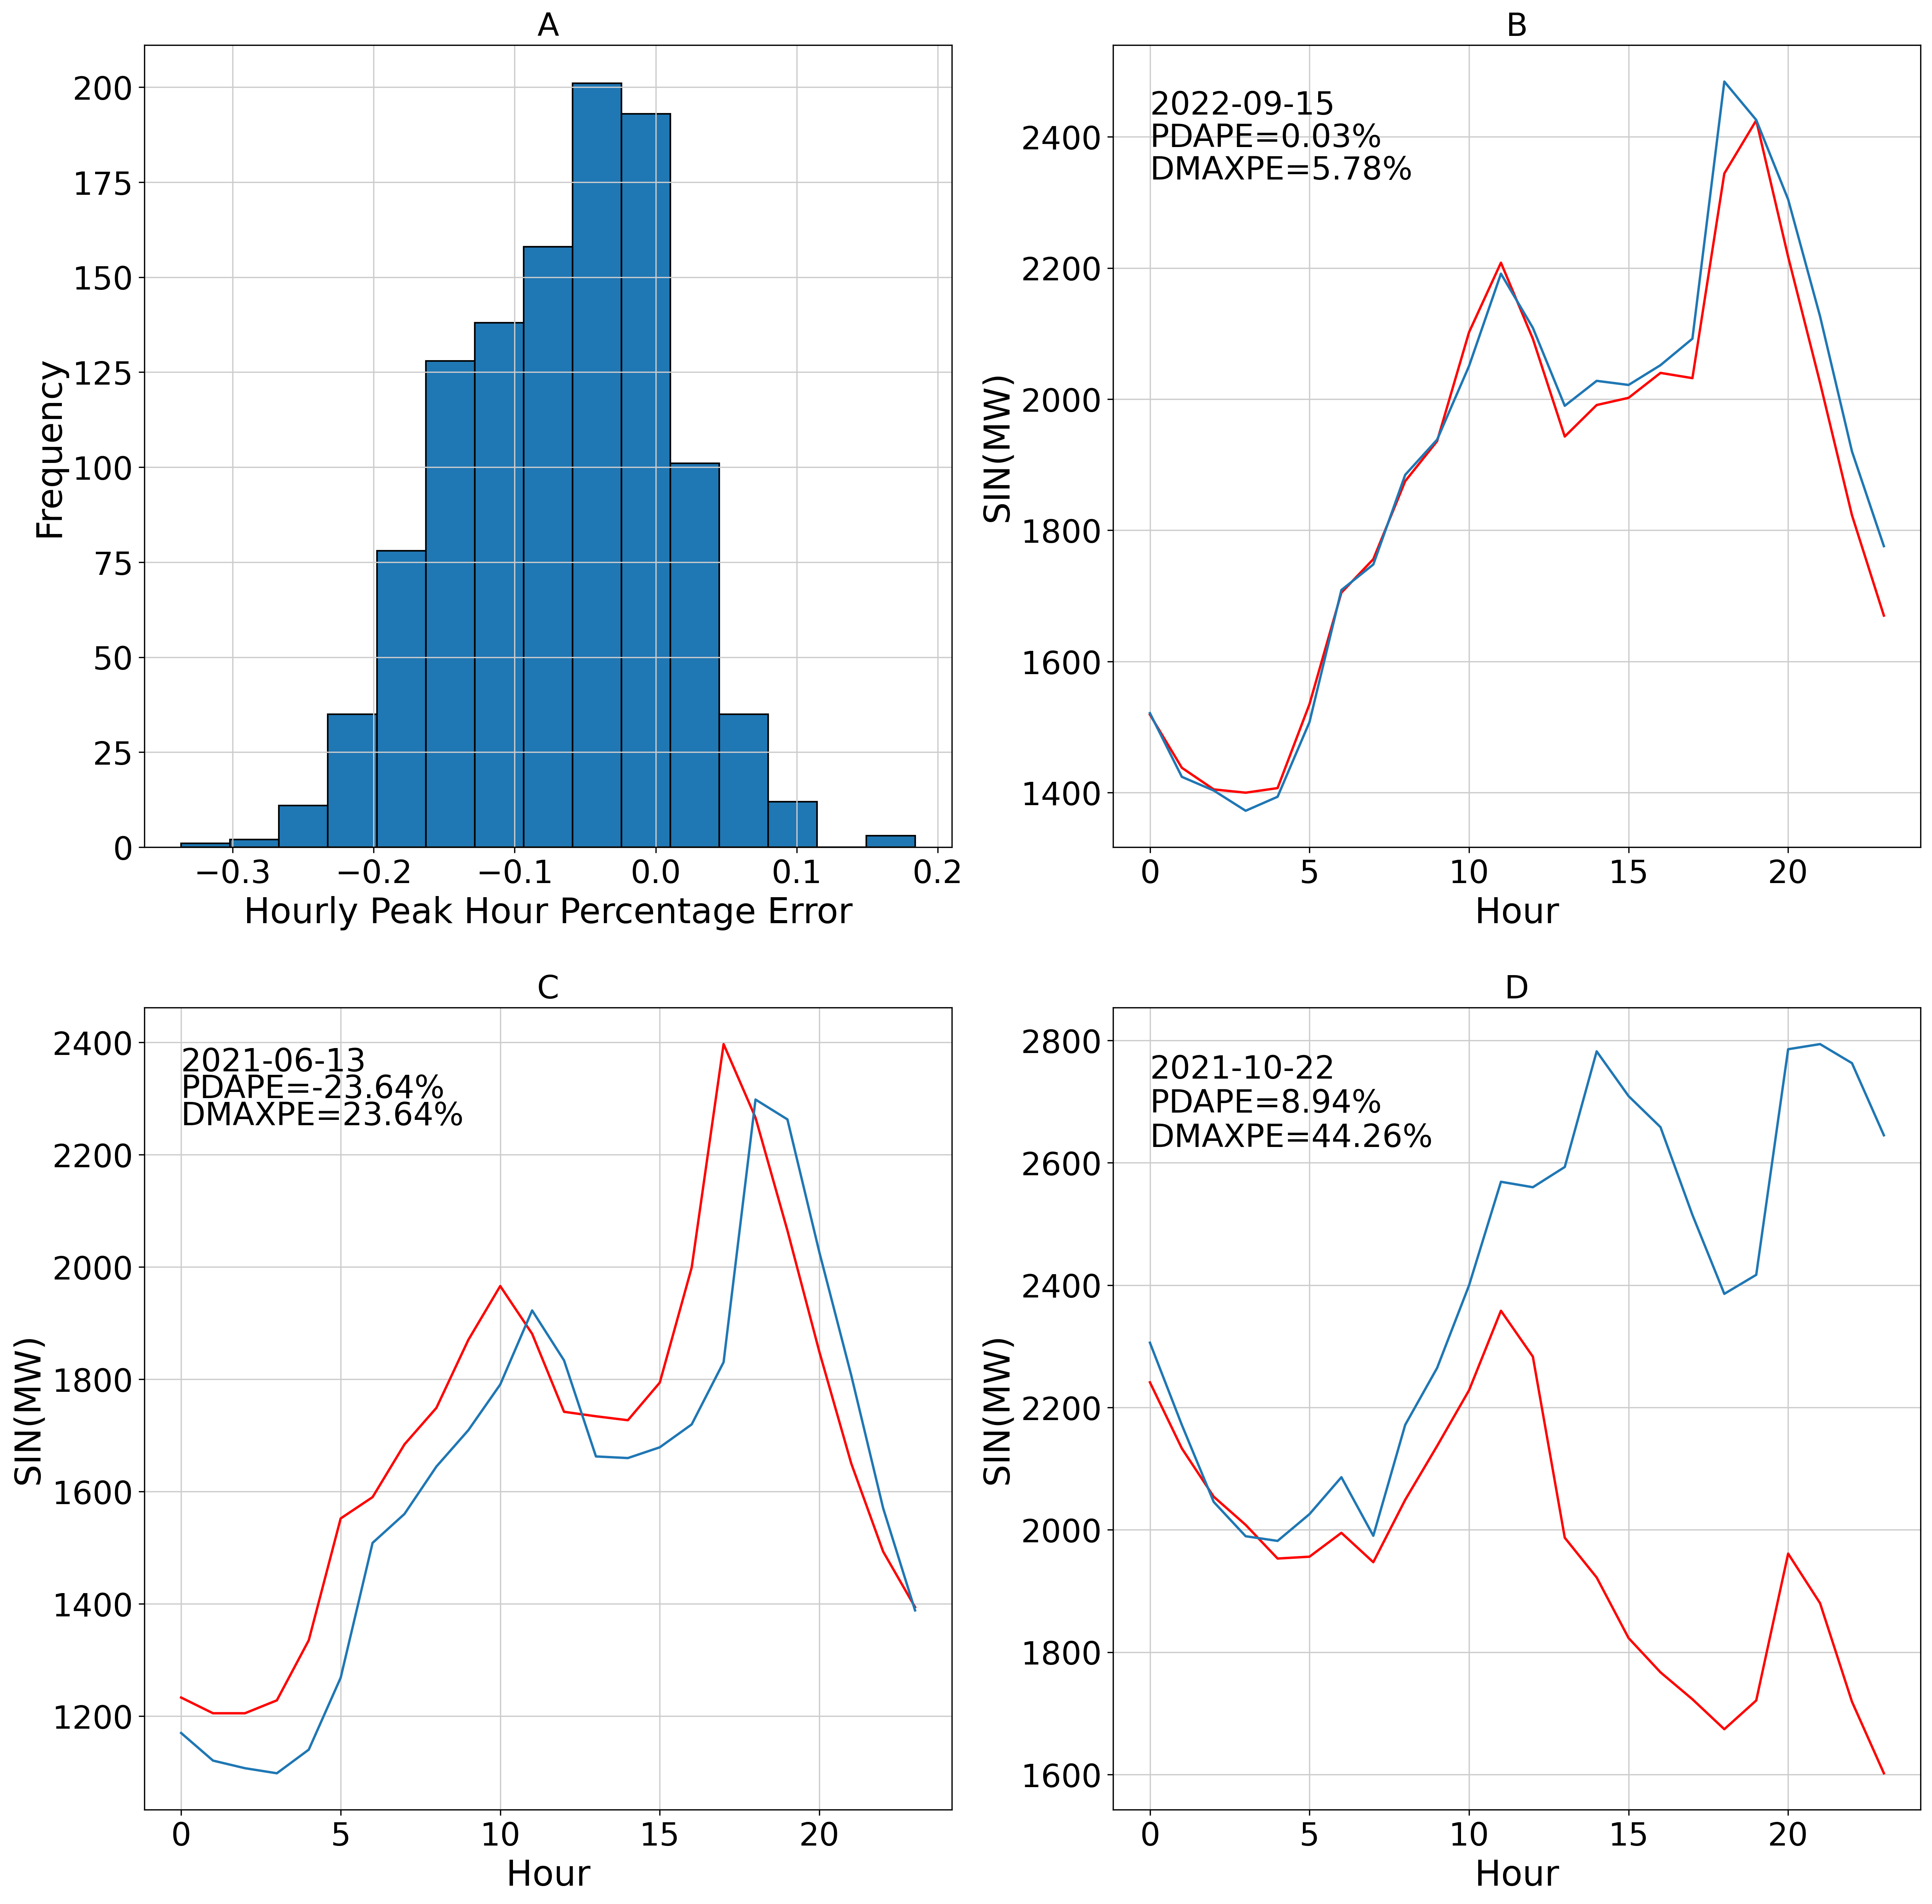

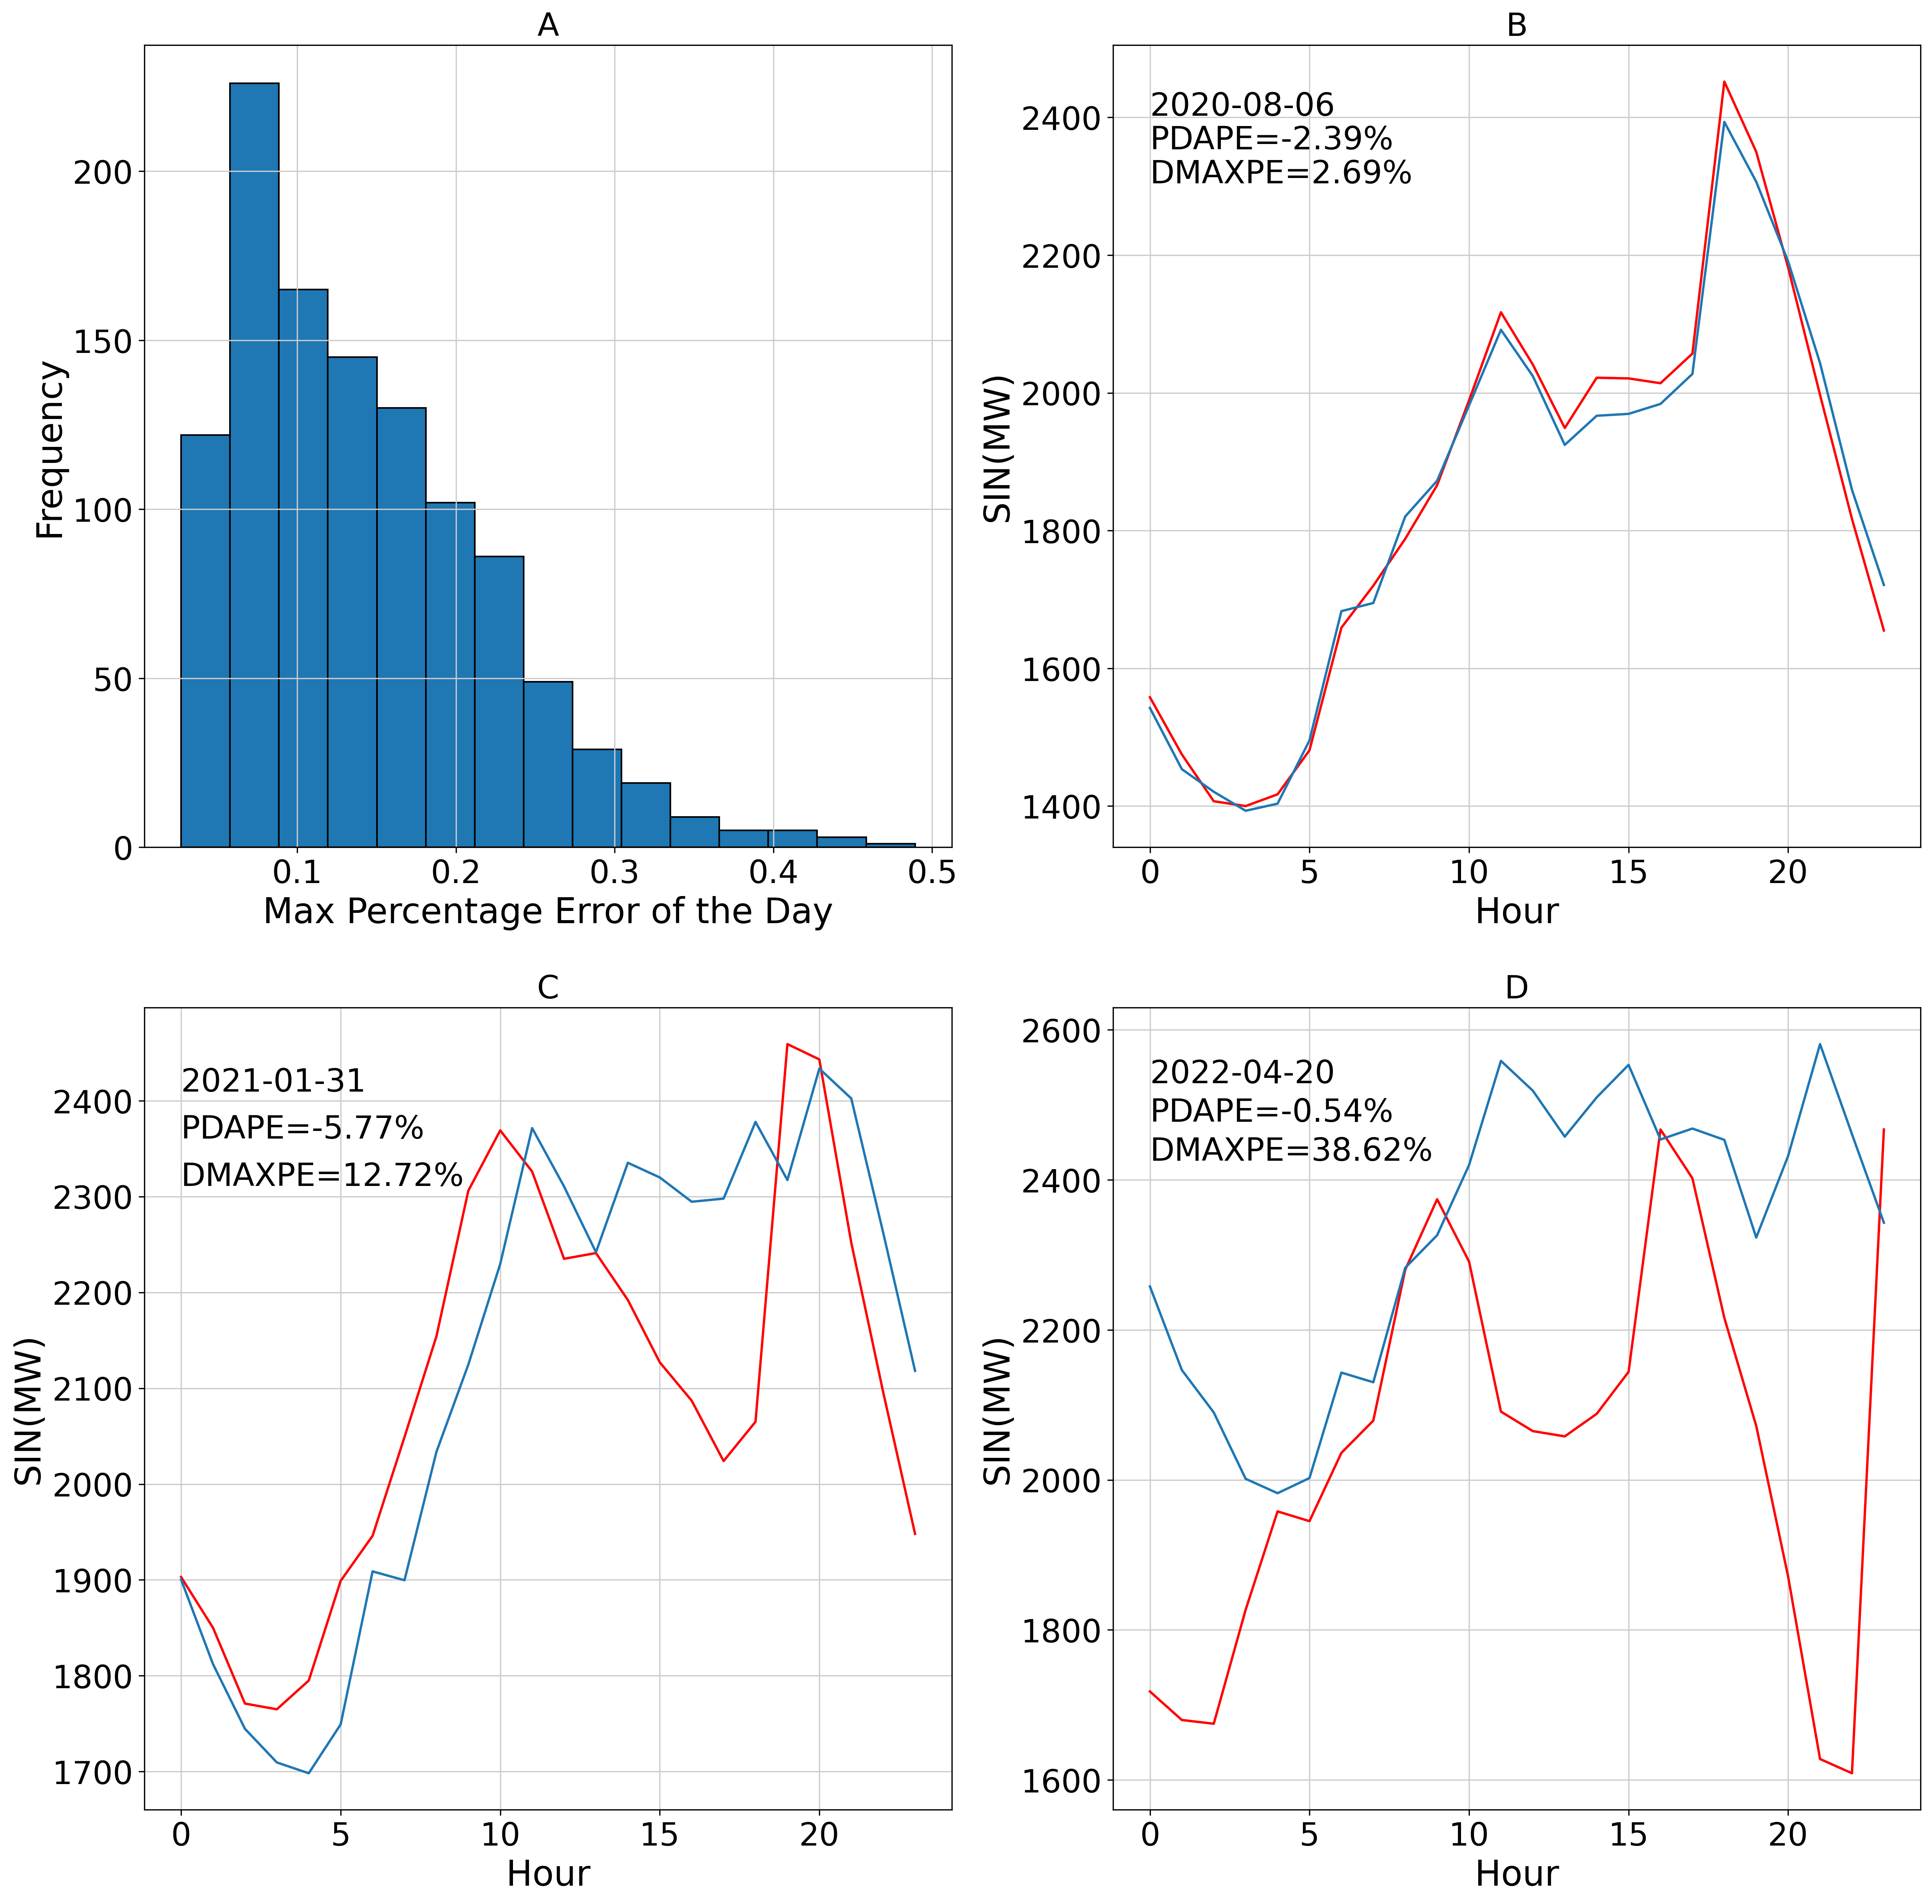

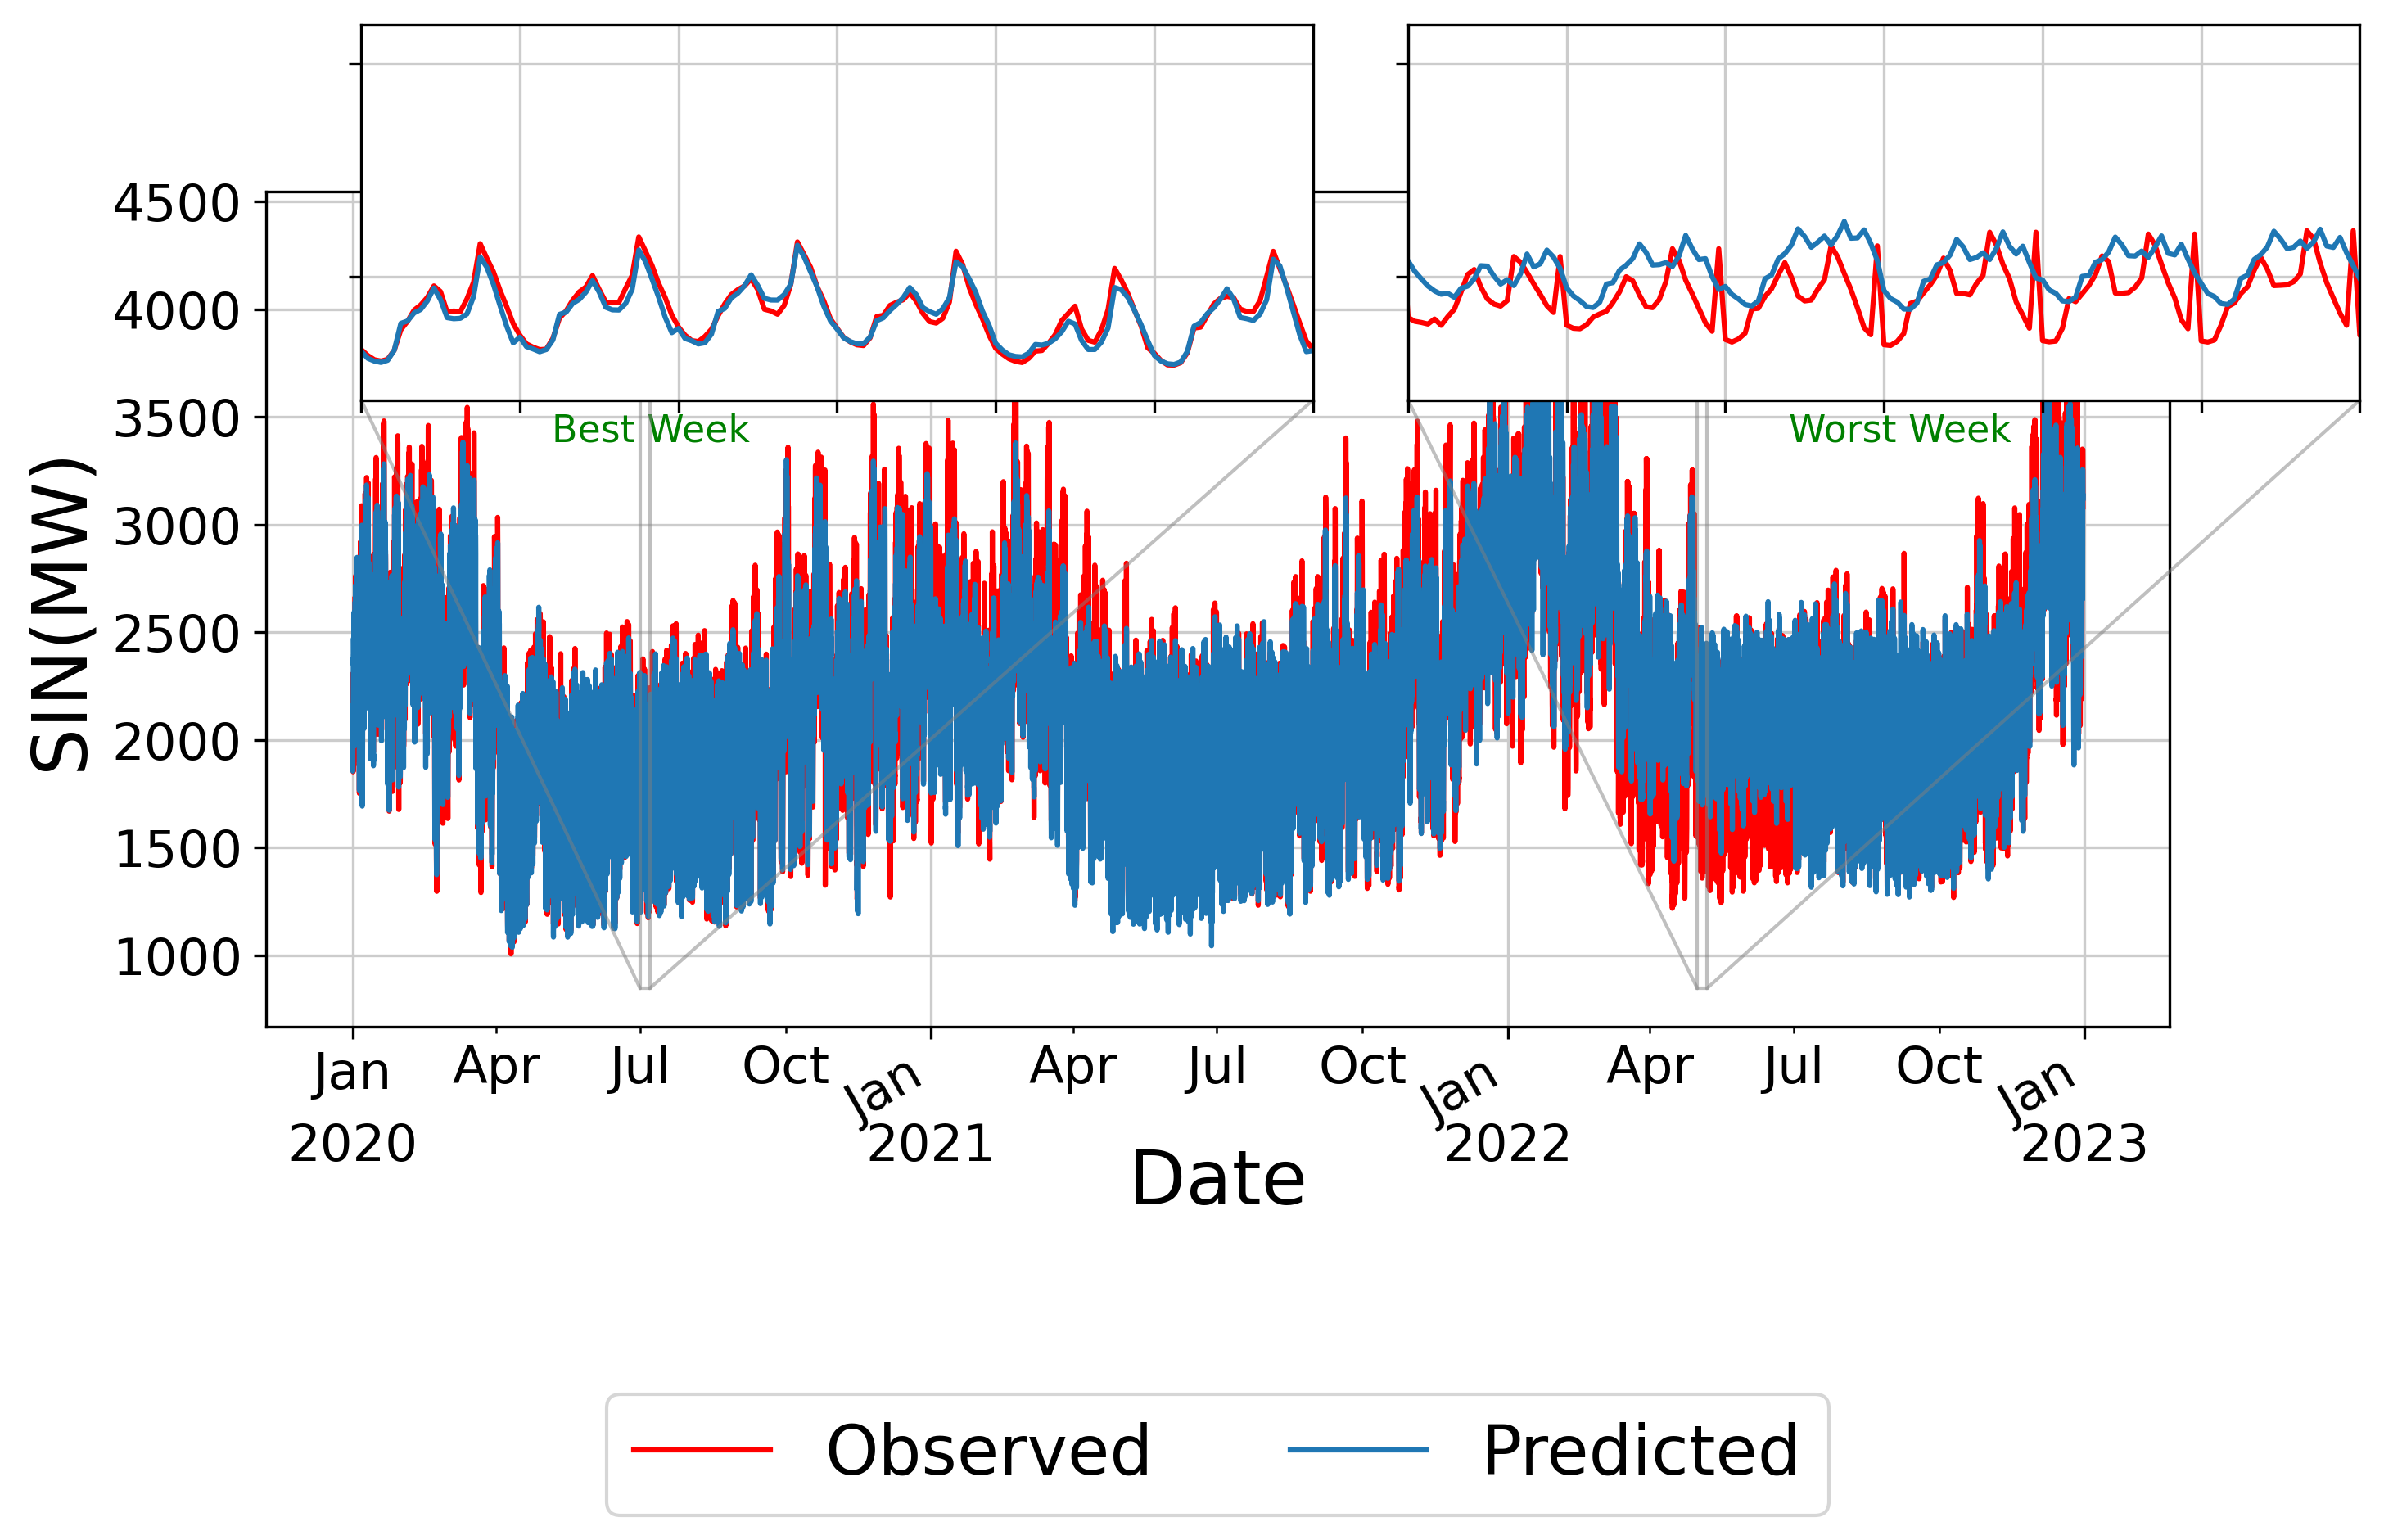

In [ ]:
#from pickle import dump,load
#from matplotlib import pyplot as plt
#import datetime as dt
#from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300
rcParams["font.size"] = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
from matplotlib import dates as mdates

modelpath='modelos/'
#model_json = model.to_json()
#with open(modelpath+"model"+model_selection+".json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights(modelpath+"model"+model_selection+".h5")

#dump(Y_val , open(modelpath+"yval.pkl", 'wb'))

#dump(predictions , open(modelpath+"model"+model_selection+"pred.pkl", 'wb'))

#ixmax=np.argmax(Y_val,axis=1)
#hmaxerr=((predictions.reshape(-1,24)[np.arange(predictions.reshape(-1,24).shape[0]),ixmax]-np.max(Y_val,axis=1))/np.max(Y_val,axis=1))
maxerr=np.max(np.abs(predictions.reshape(-1,24)-y_validation.reshape(-1,24)),axis=1)/np.max(y_validation.reshape(-1,24),axis=1)

print(np.percentile(hmaxerr,99))
print(np.percentile(hmaxerr,50))
print(np.percentile(hmaxerr,1))


fig, axes=plt.subplots(2, 2, figsize=(20, 20))
axes[0, 0].set_title('A')
axes[0, 1].set_title('B')
axes[1, 0].set_title('C')
axes[1, 1].set_title('D')
axes.flatten()[0].hist(hmaxerr,edgecolor="black",bins=15);
axes.flatten()[0].set_xlabel('Hourly Peak Hour Percentage Error')
axes.flatten()[0].set_ylabel('Frequency')
#plt.savefig("testhistrmse.png")

lista=[]
lista.append(np.argmin(np.abs(hmaxerr )))

lista.append(np.argmin(np.abs(hmaxerr - np.percentile(hmaxerr,1))))
lista.append(np.argmin(np.abs(hmaxerr -np.percentile(hmaxerr, 99))))
i=1
for dia in lista:
    maxd=max([np.max(y_validation.reshape(-1,24)[dia,:]),np.max(predictions.reshape(-1,24)[dia,:])])
    axes.flatten()[i].text(0,maxd*0.98 ,dtin[(dia-1)*24].date().strftime("%Y-%m-%d"))
    axes.flatten()[i].text(0,maxd*0.96 ,"PDAPE="+"{:.2%}".format(hmaxerr[dia]))
    axes.flatten()[i].text(0,maxd*0.94 ,"DMAXPE="+"{:.2%}".format(maxerr[dia]))
    axes.flatten()[i].plot(y_validation.reshape(-1,24)[dia,:],color='red')
    axes.flatten()[i].plot(predictions.reshape(-1,24)[dia,:])
    axes.flatten()[i].set_xlabel('Hour')
    axes.flatten()[i].set_ylabel('SIN(MW)')

    i=i+1

#fig.savefig("PanelHPE.png")

fig, axes=plt.subplots(2, 2, figsize=(20, 20))
axes[0, 0].set_title('A')
axes[0, 1].set_title('B')
axes[1, 0].set_title('C')
axes[1, 1].set_title('D')

axes.flatten()[0].hist(maxerr,edgecolor="black",bins=15);
axes.flatten()[0].set_xlabel('Max Percentage Error of the Day')
axes.flatten()[0].set_ylabel('Frequency')
#plt.savefig("testhistrmse.png")

lista=[]
lista.append(np.argmin(np.abs(maxerr)))
lista.append(np.argmin(np.abs(maxerr -np.percentile(maxerr, 50))))
lista.append(np.argmin(np.abs(maxerr -np.percentile(maxerr, 99))))
i=1
for dia in lista:
    maxd=max([np.max(y_validation.reshape(-1,24)[dia,:]),np.max(predictions.reshape(-1,24)[dia,:])])
    axes.flatten()[i].text(0,maxd*0.98 ,dtin[(dia-1)*24].date().strftime("%Y-%m-%d"))
    axes.flatten()[i].text(0,maxd*0.96 ,"PDAPE="+"{:.2%}".format(hmaxerr[dia]))
    axes.flatten()[i].text(0,maxd*0.94 ,"DMAXPE="+"{:.2%}".format(maxerr[dia]))
    axes.flatten()[i].plot(y_validation.reshape(-1,24)[dia,:],color='red')
    axes.flatten()[i].plot(predictions.reshape(-1,24)[dia,:])
    axes.flatten()[i].set_xlabel('Hour')
    axes.flatten()[i].set_ylabel('SIN(MW)')
    i=i+1

#fig.savefig("PanelMAERR.png")


print(np.percentile(maxerr,99))
print(np.percentile(maxerr,50))
print(np.percentile(maxerr,1))



fig, ax = plt.subplots(figsize=(10, 5))
fmt_month = mdates.MonthLocator(interval=3)
    # Minor ticks every year.
fmt_year = mdates.YearLocator()
ax.xaxis.set_minor_locator(fmt_month)
    # '%b' to get the names of the month
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # fontsize for month labels
ax.tick_params(labelsize=15, which='both')
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)
ax.plot(dtin,y_validation.reshape(-1)[:len(dtin)],color='red',label='Observed')
ax.plot(dtin, predictions[:len(dtin)],label='Predicted')
# Set the x-axis label
ax.set_xlabel('Date')

# Set the y-axis label
ax.set_ylabel('SIN(MW)')
zoom_start =  pd.to_datetime('2020-07-01')
zoom_end =  pd.to_datetime('2020-07-07')
axins = ax.inset_axes([0.05, 0.75, 0.5, 0.45])  # Adjust the position and size of the zoomed-in box
axins.plot(dtin,y_validation.reshape(-1)[:len(dtin)], color='red',label='Observed')
axins.plot(dtin, predictions[:len(dtin)], label='Predicted')
axins.set_xlim(zoom_start, zoom_end)
#axins.set_ylim(-2, 2)
axins.set_xticklabels([])
axins.set_yticklabels([])

# Add a box and annotate the zoomed-in region
ax.indicate_inset_zoom(axins)
ax.annotate('Best Week', xy=(0.15, 0.7), xycoords='axes fraction', fontsize=11, color='green')

zoom_start =  pd.to_datetime('2022-05-01')
zoom_end =  pd.to_datetime('2022-05-07')
axins = ax.inset_axes([0.6, 0.75, 0.5, 0.45])  # Adjust the position and size of the zoomed-in box
axins.plot(dtin,y_validation.reshape(-1)[:len(dtin)], color='red',label='Observed')
axins.plot(dtin, predictions[:len(dtin)], label='Predicted')
axins.set_xlim(zoom_start, zoom_end)
#axins.set_ylim(-2, 2)
axins.set_xticklabels([])
axins.set_yticklabels([])

# Add a box and annotate the zoomed-in region
ax.indicate_inset_zoom(axins)
ax.annotate('Worst Week', xy=(0.8, 0.7), xycoords='axes fraction', fontsize=11, color='green')

# Show the legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)

# Adjust the layout to prevent overlapping labels
fig.autofmt_xdate()

#fig.savefig("Prediction.png")
# Display the plot



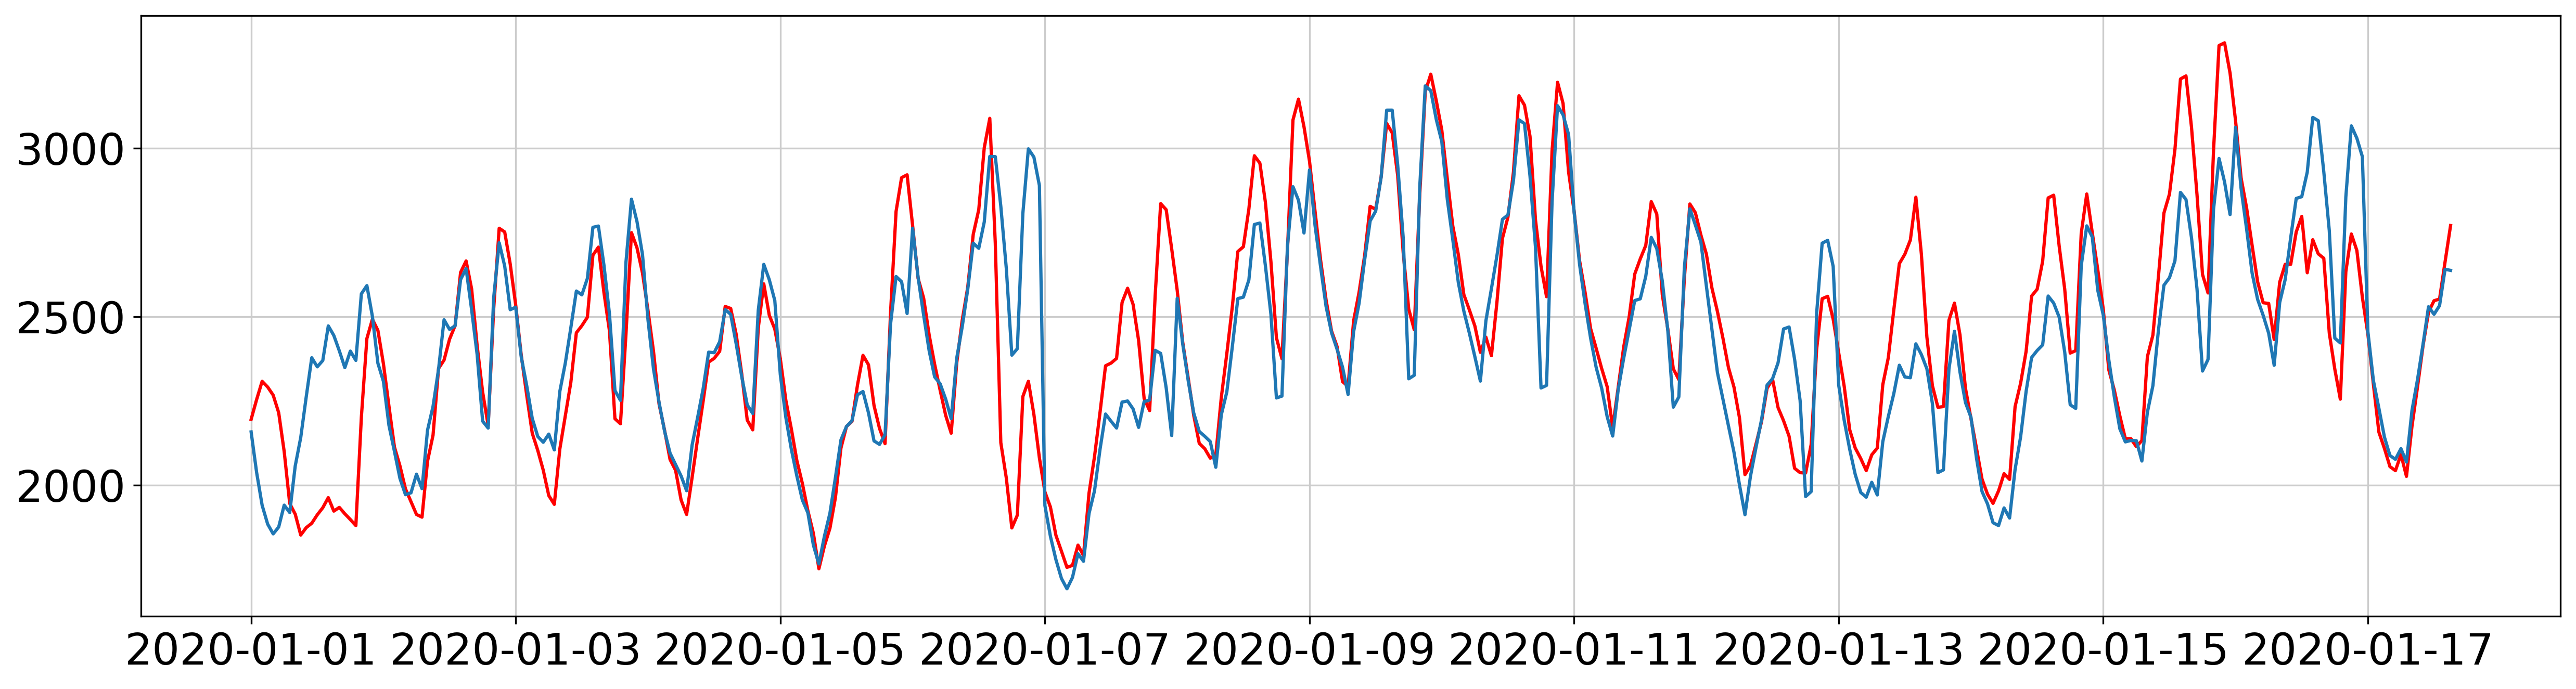

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(dtin[:400],y_validation.reshape(-1)[:400],color='red')
plt.plot(dtin[:400], predictions[:400])

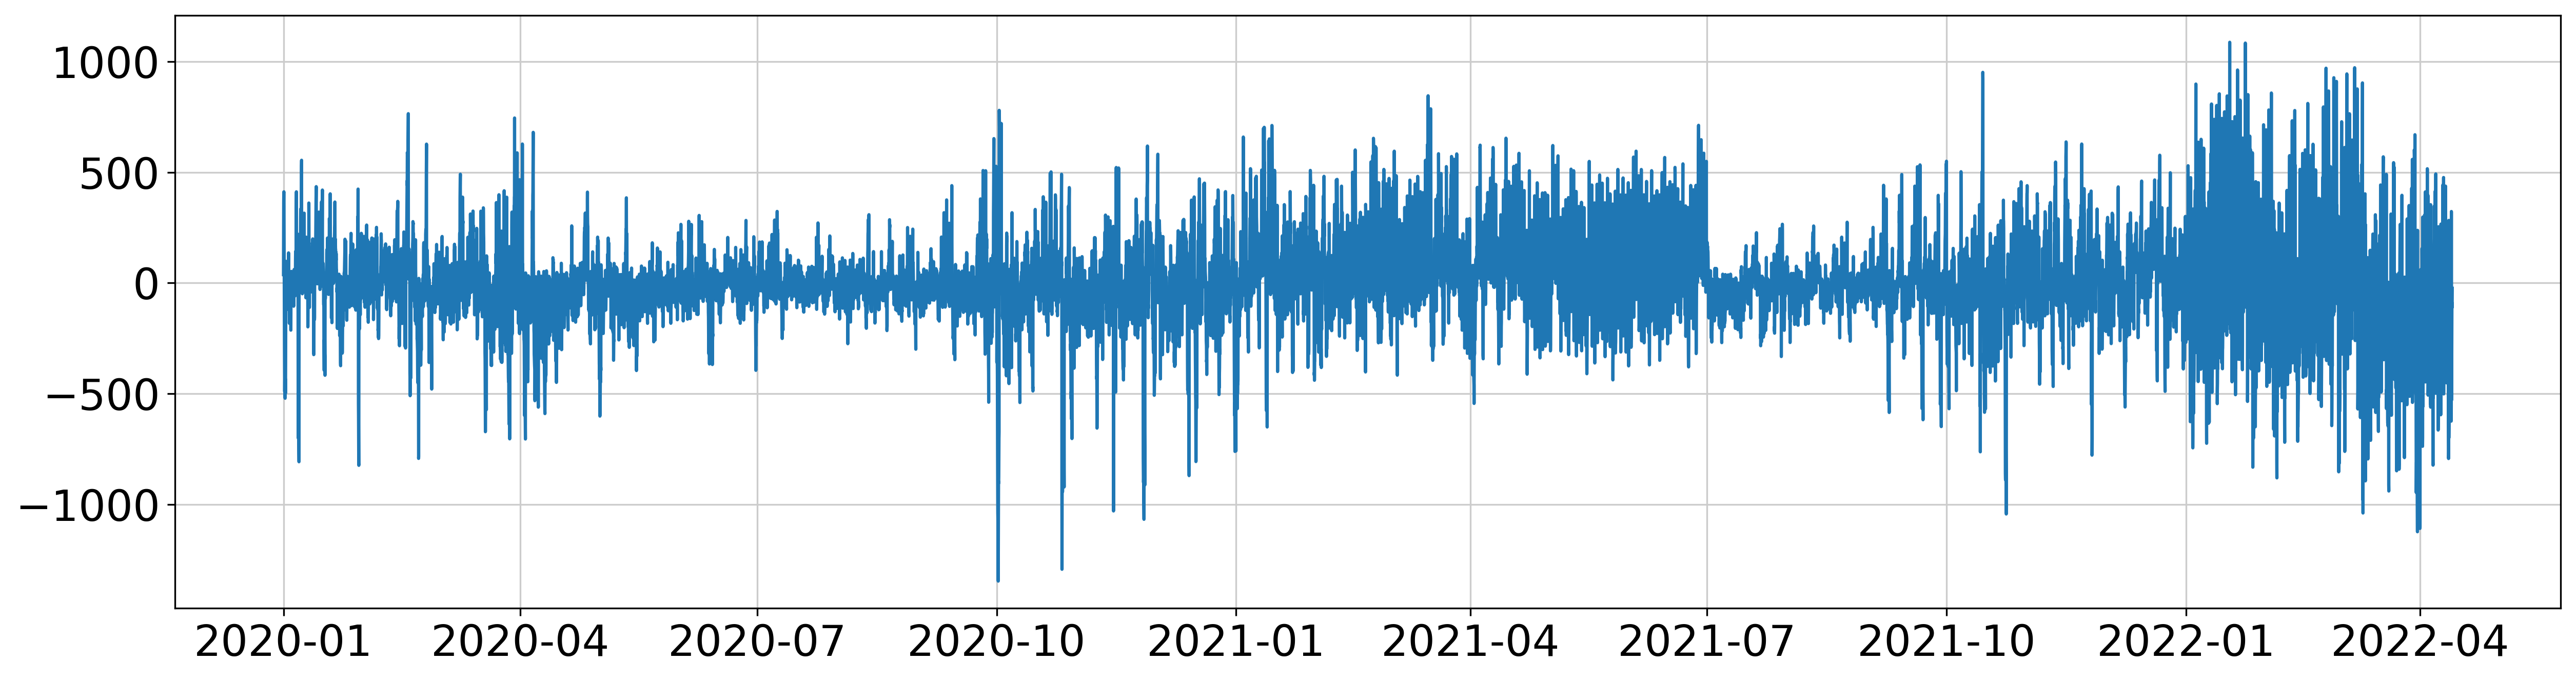

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(dtin[:20000],y_validation.reshape(-1)[:20000]-predictions[:20000])